In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

### Loading the data

In [2]:
data_train = np.load('data/fashion_train.npy', mmap_mode='r')
data_test = np.load('data/fashion_test.npy', mmap_mode='r')

In [3]:
X_train = data_train[:, :-1]
y_train = data_train[:, -1]
X_test = data_test[:, :-1]
y_test = data_test[:, -1]

### Standadizing the data

In [4]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Visualisation and exploratory data analysis

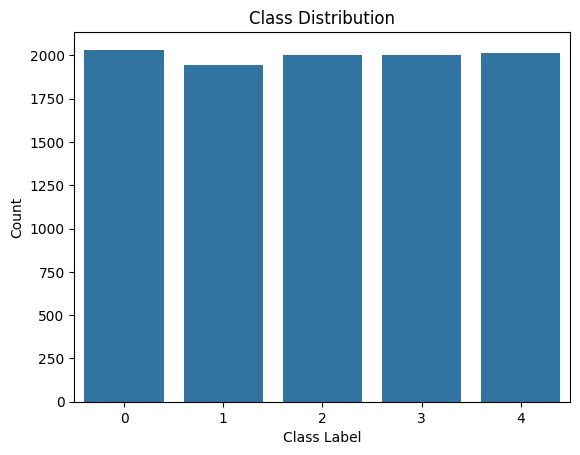

In [5]:

# Plot the distribution of classes
sns.countplot(x=y_train)
plt.title('Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

In [6]:
labels_count = [np.sum(y_train == i) for i in range(5)]
labels_count

[2033, 1947, 2001, 2005, 2014]

In [7]:
# Class dict
class_dict = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Shirt'}

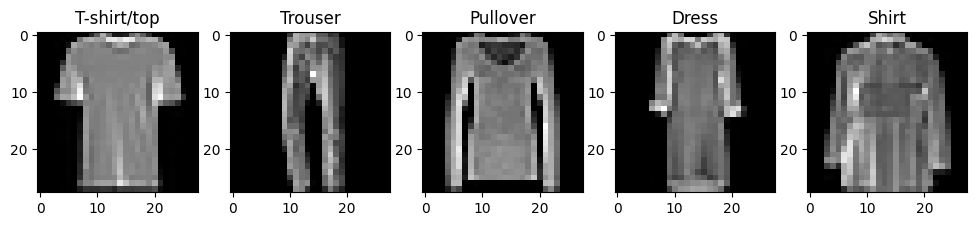

In [8]:
fig, ax = plt.subplots(1, 5, figsize=(12,5))

for i in range(5):
    ax[i].imshow(X_train[y_train==i][0].reshape(28,28), cmap = 'gray')
    ax[i].set_title(f'{class_dict[i]}')

plt.savefig('img/categories')

## LDA

In [9]:
from scipy.linalg import inv
from numpy.linalg import eig

In [10]:
class LDA():
    def __init__(self, n_components):
        self.n_components = n_components
        self.linear_discriminants = None

        self.class_labels = None

    def fit(self, X, y):
        n_features = X.shape[1]
        N = X.shape[0]
        self.class_labels = np.unique(y)
        
        means = np.mean(X, axis=0)

        SW = np.zeros((n_features, n_features))
        SB = np.zeros((n_features, n_features))

        for c in self.class_labels:
            # Find within class scatter matrix
            X_c = X[y==c]
            mean_c = np.mean(X_c, axis=0)

            # Sum of SW_c
            SW += (X_c -mean_c).T.dot((X_c-mean_c))

            # Find between class scatter matrix
            n_c = X_c.shape[0]
            mean_diff = (mean_c - means).reshape(n_features,1)

            # Sum of SB
            SB += n_c * (mean_diff).dot(mean_diff.T)

        # Find the inverse of SW
        SW_inv = inv(SW)

        # Find SW^-1SB
        A = SW_inv.dot(SB)

        # Find the eigenvectors and eigenvalues of A
        eigenvalues, eigenvectors = eig(A)
        eigenvectors = eigenvectors.T

        # Get indexes of maximum eigenvalues
        idx = np.argsort(eigenvalues.real)[::-1]

        # Get sorted eigenvalues and eigenvectors
        eigenvalues, eigenvectors = eigenvalues[idx], eigenvectors[idx].real

        # Save the n first eigenvectors
        self.linear_discriminants = eigenvectors[:self.n_components]

    def transform(self, X):
        return np.dot(X, self.linear_discriminants.T)

### Visualization of LDA components

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

Train the classifier, and get the transformed data for visualisation.

In [12]:
# Train classifier
clf = LDA(n_components=4)
clf.fit(X_train_std, y_train)

# Transform data
X_train_transformed = clf.transform(X_train_std)

In [13]:
# Convert to pandas data frame
ld_df = pd.DataFrame(data=np.hstack([X_train_transformed,y_train.reshape(-1,1)]), columns=['LD1', 'LD2', 'LD3', 'LD4','label'])

In [14]:
# Class dict
class_dict = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Shirt'}
colors = ["navy", "turquoise", "green", 'blue', 'lightblue']

In [15]:
def plot_lda(X, y, img_label):
    fig, ax = plt.subplots()
    class_dict = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Shirt'}
    colors = ["navy", "turquoise", "green", 'blue', 'lightblue']

    for k, c in enumerate(colors):
        sns.scatterplot(data=X[y == k], x='LD1', y='LD2', alpha=0.8, color=c, label=class_dict[k], ax=ax)

    # Optionally save the figure
    plt.savefig(f"img/{img_label}")

    plt.show()  # Display the plot

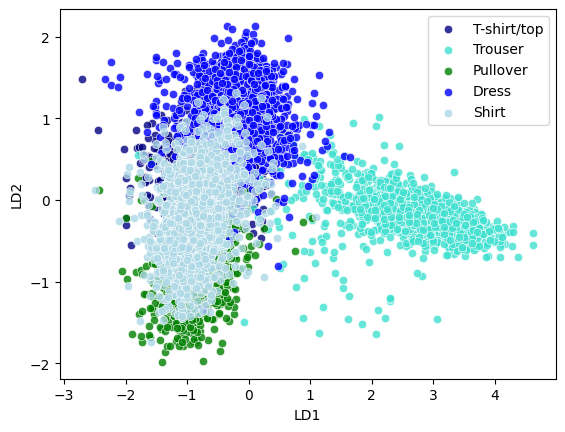

In [16]:
plot_lda(ld_df, y_train, 'our_lda')

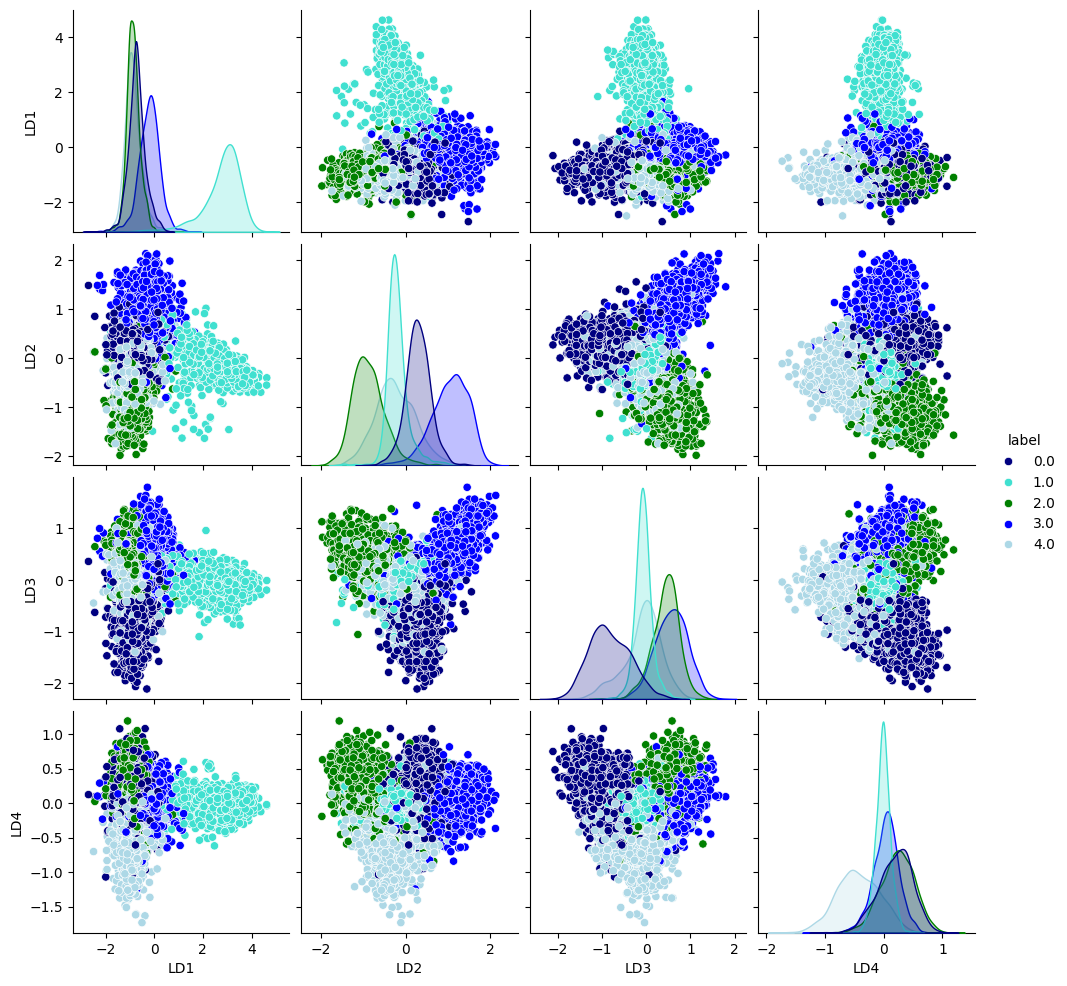

In [17]:
sns.pairplot(ld_df, hue='label', palette={i: colors[i] for i in range(len(colors))});

plt.savefig('img/our_lda_pairplot')
plt.show()

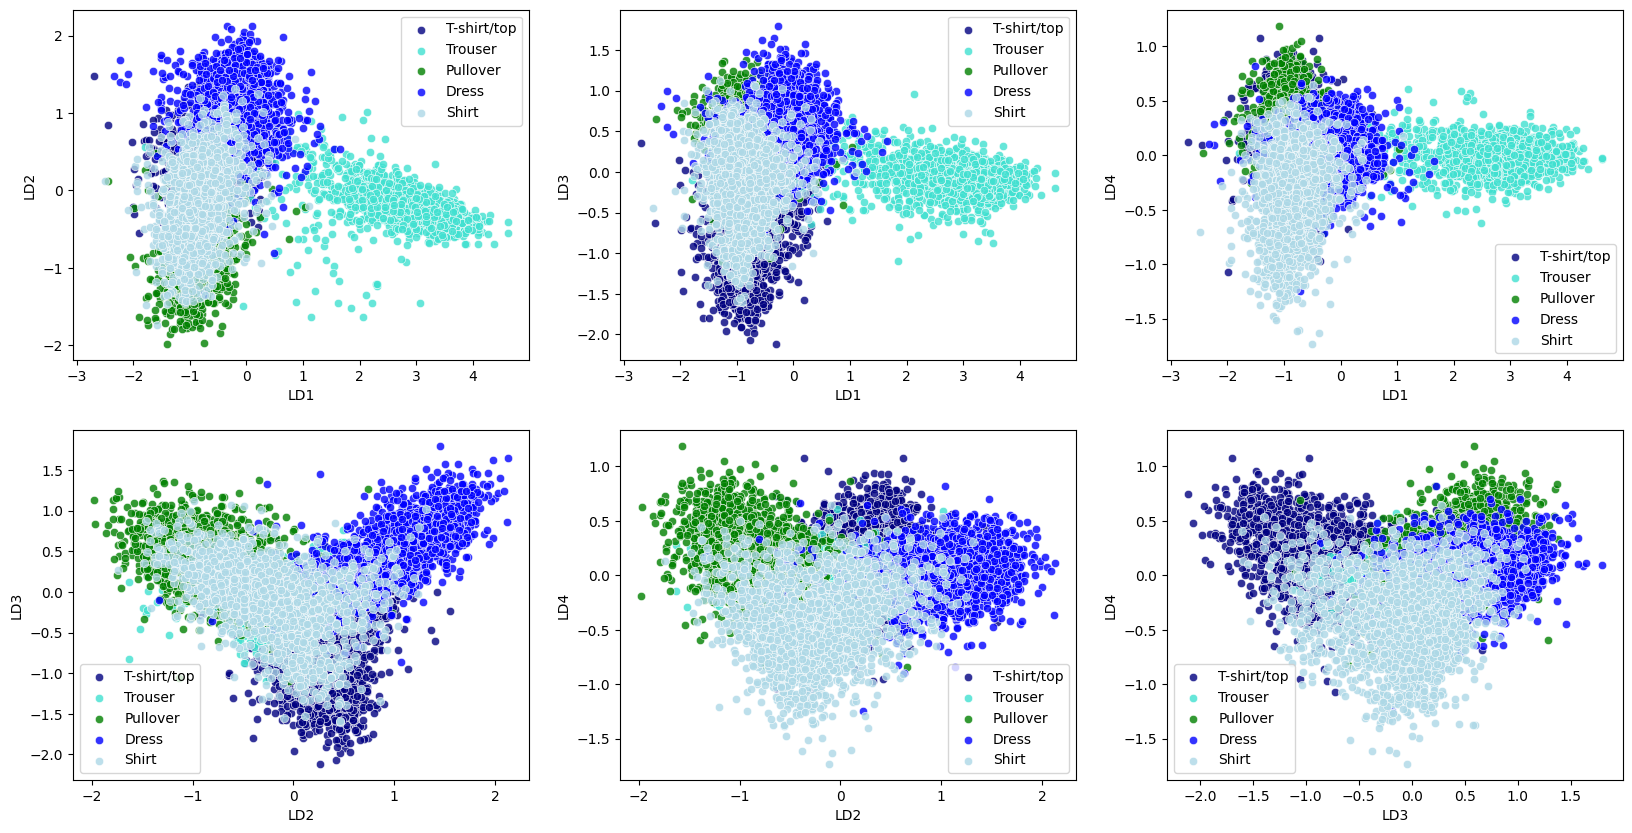

In [18]:
fig, ax = plt.subplots(2, 3, figsize = (20,10))

colors = ["navy", "turquoise", "green", 'blue', 'lightblue'] 
components = ['LDA1', 'LDA2', 'LDA3', 'LDA4']

for k, c in enumerate(colors):
    sns.scatterplot(data= ld_df[y_train == k], x='LD1', y='LD2', alpha=0.8, color=c, label=class_dict[k], ax=ax[0,0])

for k, c in enumerate(colors):
    sns.scatterplot(data=ld_df[y_train == k], x='LD1', y='LD3', alpha=0.8, color=c, label=class_dict[k], ax=ax[0,1])

for k, c in enumerate(colors):
    sns.scatterplot(data=ld_df[y_train == k], x='LD1', y='LD4', alpha=0.8, color=c, label=class_dict[k], ax=ax[0,2])

for k, c in enumerate(colors):
    sns.scatterplot(data=ld_df[y_train == k], x='LD2', y='LD3', alpha=0.8, color=c, label=class_dict[k], ax=ax[1,0])

for k, c in enumerate(colors):
    sns.scatterplot(data=ld_df[y_train == k], x='LD2', y='LD4', alpha=0.8, color=c, label=class_dict[k], ax=ax[1,1])

for k, c in enumerate(colors):
    sns.scatterplot(data=ld_df[y_train == k], x='LD3', y='LD4', alpha=0.8, color=c, label=class_dict[k], ax=ax[1,2])

### Verification of results

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [20]:
# Train classifer
clf = LinearDiscriminantAnalysis(n_components=4, solver='eigen')
clf.fit(X_train_std, y_train)

# Transform data
X_train_transformed = clf.transform(X_train_std)

In [21]:
# Convert to pandas data frame
ld_df = pd.DataFrame(data=np.hstack([X_train_transformed,y_train.reshape(-1,1)]), columns=['LD1', 'LD2', 'LD3', 'LD4','label'])

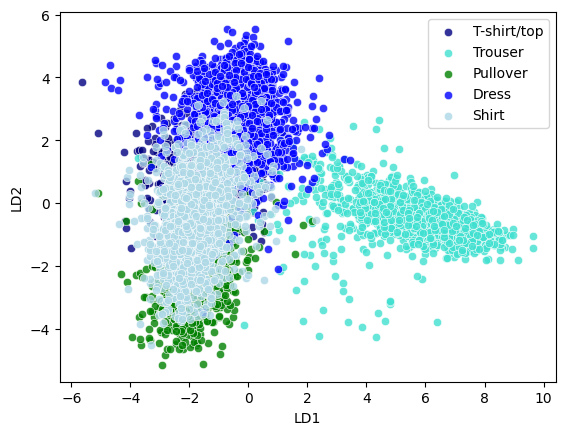

In [22]:
plot_lda(ld_df, y_train, 'sklearn_lda')

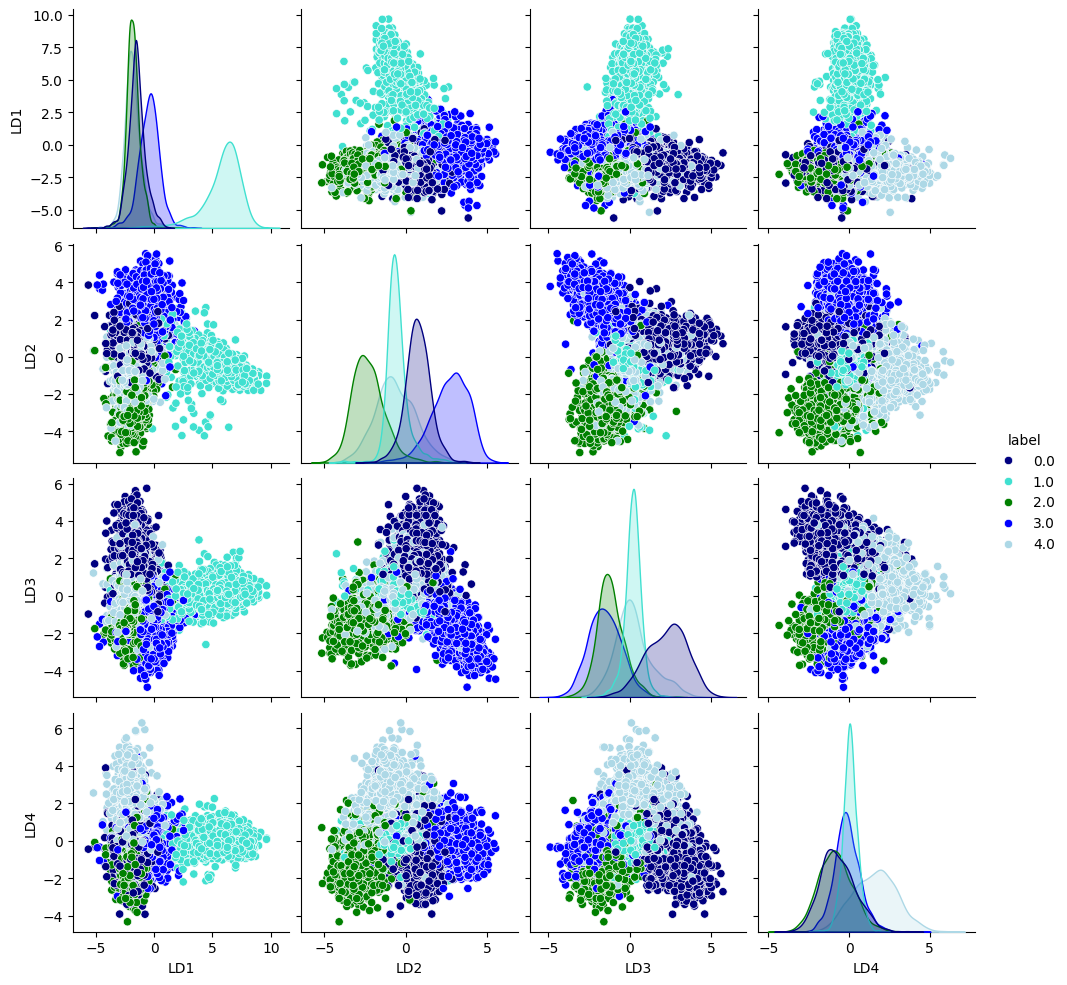

In [23]:
sns.pairplot(ld_df, hue='label', palette={i: colors[i] for i in range(len(colors))});

## PCA

In [24]:
from sklearn.decomposition import PCA
from scipy.stats.mstats import mquantiles
from sklearn.preprocessing import StandardScaler


In [25]:
std = StandardScaler()
X_train_std = std.fit_transform(X_train)

# Perform PCA
pca = PCA(n_components=2)
pca.fit(X_train_std)
principal_components = pca.transform(X_train_std)

# Convert to pandas data frame
pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

### Visulaziation of the first two components

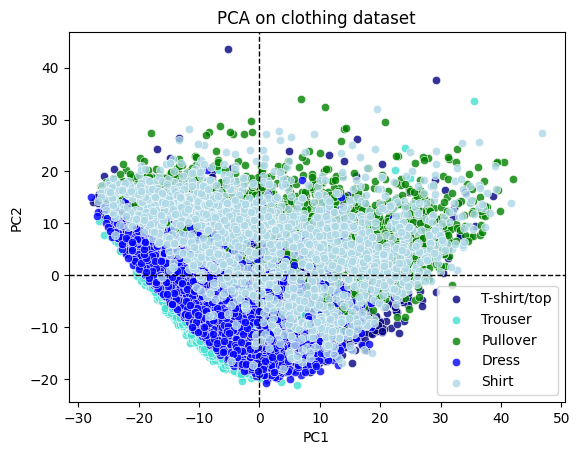

In [26]:
plt.figure()

colors = ["navy", "turquoise", "green", 'blue', 'lightblue']
lw = 2

for color, i in zip(colors, [0, 1, 2, 3, 4]):
    sns.scatterplot(
        pc_df[y_train == i], x='PC1', y='PC2', alpha=0.8, color=color, label=class_dict[i]
    )
# Plotting x-axis (y=0 line)
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Plotting y-axis (x=0 line)
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA on clothing dataset")
plt.show()

In [27]:
std = StandardScaler()
X_train_std = std.fit_transform(X_train)

# Perform PCA
pca = PCA(n_components=4)
pca.fit(X_train_std)
principal_components = pca.transform(X_train_std)

In [28]:
# Convert to pandas data frame
pc_df = pd.DataFrame(data=np.hstack([principal_components,y_train.reshape(-1,1)]), columns=['PC1', 'PC2', 'PC3', 'PC4','label'])

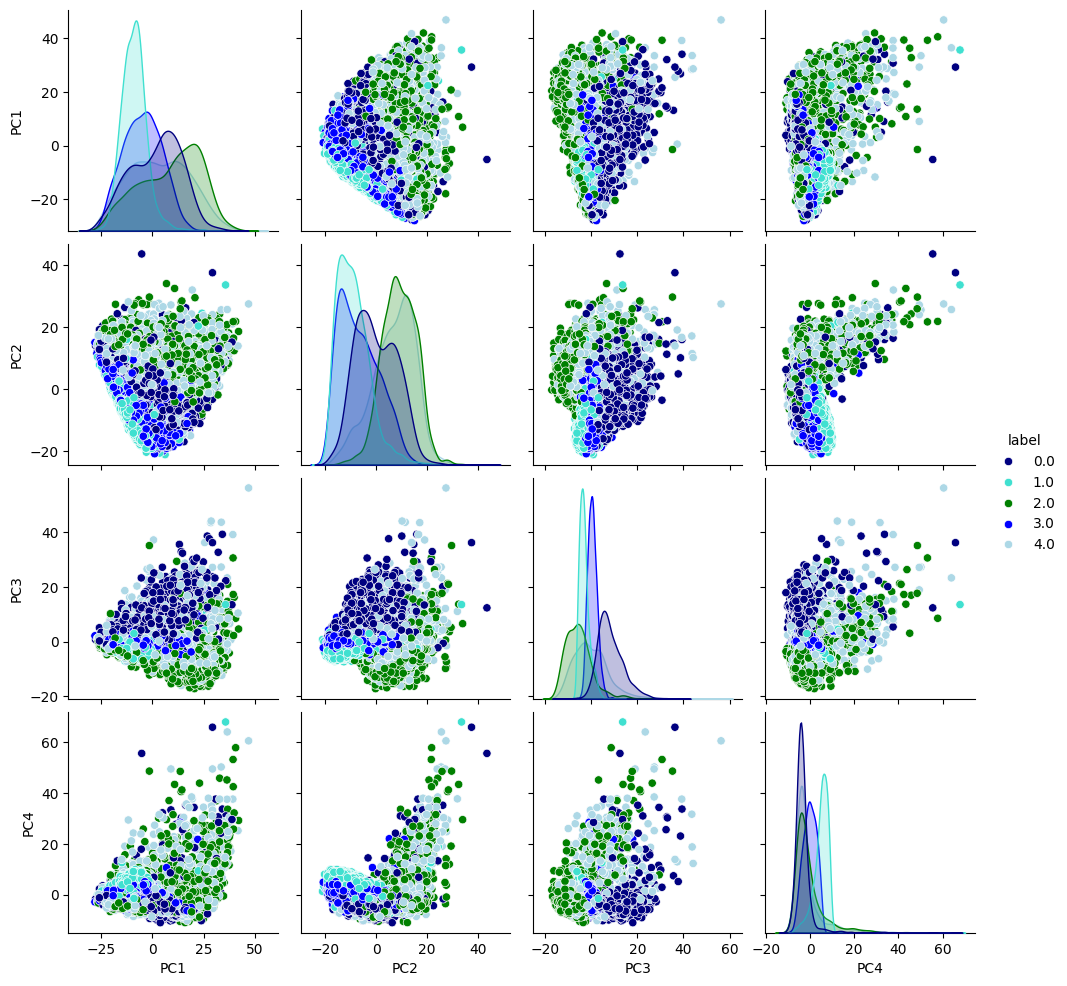

In [29]:
sns.pairplot(pc_df, hue='label', palette={i: colors[i] for i in range(len(colors))});

### Interpretation of the first two principal components

In [30]:
# Number of components required to explain 90 % of the variance in the data.
pca = PCA(n_components=0.9)
pca.fit(X_train_std);

print(f'Number of components required to explain 90 % of the data: {pca.n_components_}')

# Number of components required to explain 50 % of the variance in the data.
pca = PCA(n_components=0.5)
pca.fit(X_train_std);

print(f'Number of components required to explain 50 % of the data: {pca.n_components_}')

Number of components required to explain 90 % of the data: 112
Number of components required to explain 50 % of the data: 5


Text(0, 0.5, 'cumuliative explained variance')

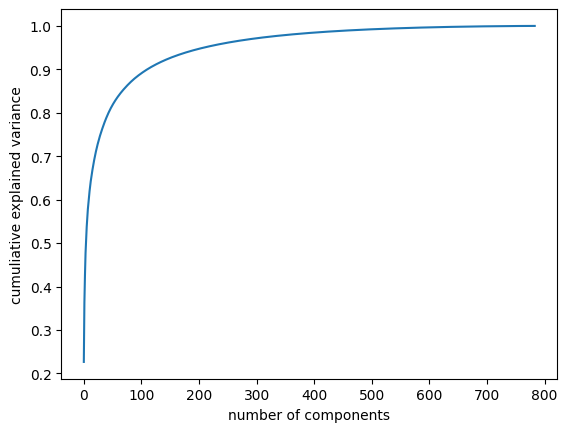

In [31]:
pca = PCA(n_components=784)
pca_transformed_X_train = pca.fit_transform(X_train_std)

#plotting the cumuliative explained variance for number of components 
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumuliative explained variance')

We will vizualise the first two principal components.

In [32]:
# Perform PCA
pca = PCA(n_components=2)
pca.fit(X_train_std)
X_train_transformed = pca.transform(X_train_std)

# Convert to pandas data frame
pc_df = pd.DataFrame(data=X_train_transformed, columns=['PC1', 'PC2'])

In [33]:
print (f'Proportion of Variance Explained : {sum(pca.explained_variance_ratio_):.2f}') 

Proportion of Variance Explained : 0.36


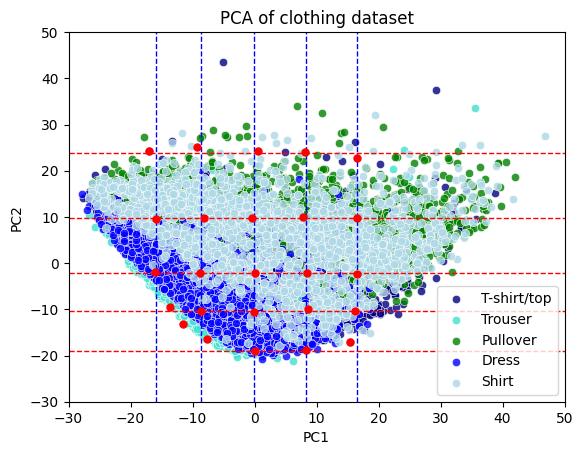

In [34]:
# Set limits for x and y axes
xlim = (-30, 50)
ylim = (-30, 50)

# Scatter plot of PC1 vs PC2
for color, i in zip(colors, [0, 1, 2, 3, 4]):
    sns.scatterplot(
        pc_df[y_train == i], x='PC1', y='PC2', alpha=0.8, color=color, label=class_dict[i]
    )

# Calculate marginal quantiles for PC1 and PC2
quantiles_pc1 = mquantiles(pc_df['PC1'], prob=[0.05,0.25,0.5,0.75,0.95])
quantiles_pc2 = mquantiles(pc_df['PC2'], prob=[0.05,0.25,0.5,0.75,0.95])

# Plotting quantiles on the sides of the scatter plot
for q in quantiles_pc1:
    plt.axhline(q, linestyle='--', linewidth=1, color='red')  # Adjust the color as needed

for q in quantiles_pc2:
    plt.axvline(q, linestyle='--', linewidth=1, color='blue')  # Adjust the color as needed

# Plot target coordinates
num_quantiles_pc1 = len(quantiles_pc1)
num_quantiles_pc2 = len(quantiles_pc2)

target_coordinates = np.array([[quantiles_pc2[i], quantiles_pc1[j]] for i in range(num_quantiles_pc1) for j in range(num_quantiles_pc2)])
for i, target_coord in enumerate(target_coordinates):

    # Calculate Euclidean distances
    distances = np.linalg.norm(pc_df - target_coord, axis=1)

    # Find the index of the point with the smallest distance
    closest_point_index = np.argmin(distances)

    plt.plot(pc_df['PC1'].iloc[closest_point_index],pc_df['PC2'].iloc[closest_point_index], marker='o', markersize=5, color='red')

# Set limits for x and y axes
plt.xlim(xlim)
plt.ylim(ylim)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of clothing dataset')
plt.savefig('img/pca_quantiles.png')
plt.show()


In [35]:
def visualise_pc(pc_df, X, target_coordinates, title):
    num_cols = len(quantiles_pc1)
    num_rows = len(quantiles_pc2)
    
    # Create a grid of subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10), sharex=True, sharey=True)

    for i, target_coord in enumerate(target_coordinates):
        # Calculate Euclidean distances
        distances = np.linalg.norm(pc_df - target_coord, axis=1)

        # Find the index of the point with the smallest distance
        closest_point_index = np.argmin(distances)
        closest_image = X[closest_point_index].reshape(28, 28)

        # Determine subplot position
        col_position = i // num_cols
        row_position = num_rows-1 -i % num_rows

        # Display the image in the subplot
        axes[row_position, col_position].imshow(closest_image, cmap='gray')
        axes[row_position, col_position].set_title(title[i])

    # Remove empty subplots
    for i in range(len(target_coordinates), num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.savefig("img/visualise_pc_img.png")
    plt.show()

In [36]:
num_quantiles_pc1 = len(quantiles_pc1)
num_quantiles_pc2 = len(quantiles_pc2)

target_coordinates = np.array([[quantiles_pc2[i], quantiles_pc1[j]] for i in range(num_quantiles_pc1) for j in range(num_quantiles_pc2)])
title = np.array([f'$q_{{{i}}}\_pc_1$, $q_{{{j}}}\_pc_2$' for i in [0.05,0.25,0.5,0.75,0.95] for j in [0.05,0.25,0.5,0.75,0.95]])

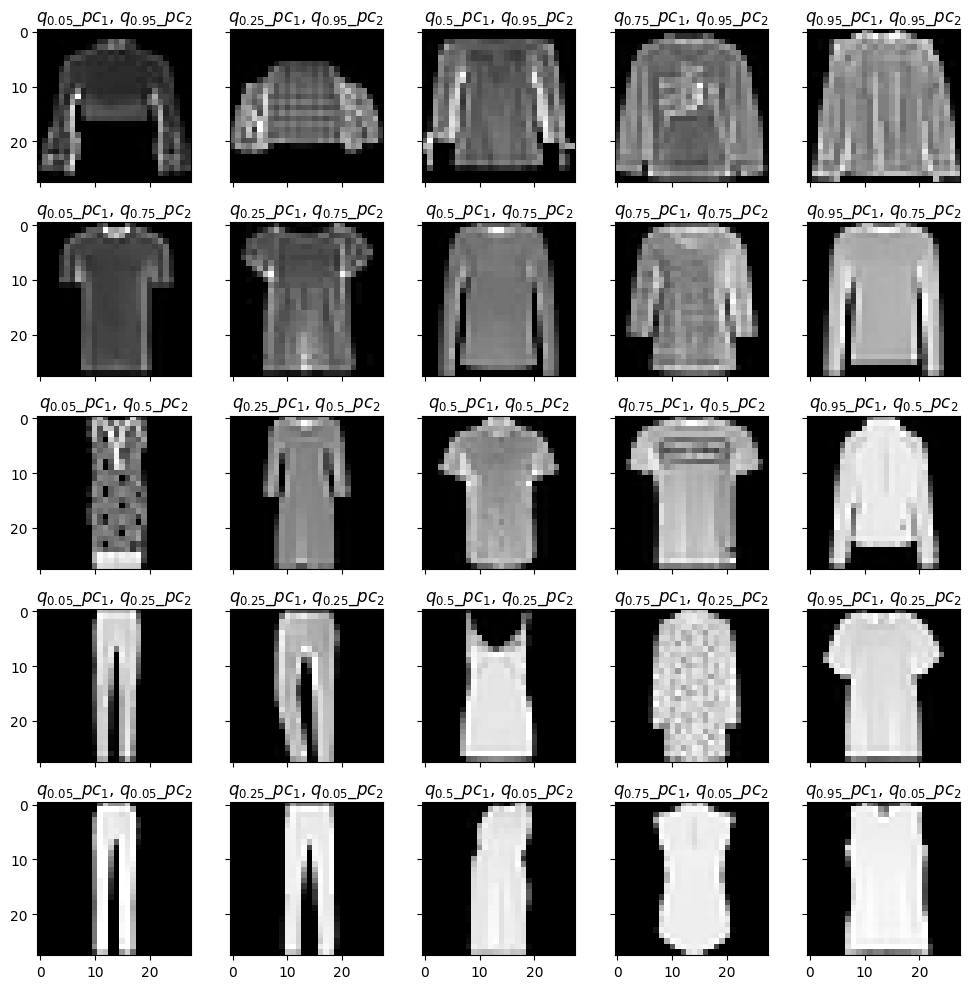

In [37]:
visualise_pc(pc_df, X_train, target_coordinates, title)